In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import shelve
import os
import sys
import datetime
import GPy
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator, aslinearoperator, norm as spnorm
from scipy.sparse import coo_array

In [2]:
from pyoed.models.error_models.Gaussian import GaussianErrorModel
from pyoed.oed.sensor_placement.binary_oed import SensorPlacementBinaryOED
from pyoed.assimilation.smoothing.fourDVar import VanillaFourDVar 

Add the directory to enable imports.

In [3]:
sys.path.append('../')

In [4]:
from python.prob_setup import setup_advdiff1D
from python.randsubset import create_pyoed_oper, create_noise_oper, A_forward_op, A_adjoint_op # pyoed operator setup
from python.randsubset import detcssp, randcssp, greedydopt # CSSP operations
from python.randsubset import randsvd, colsample, compute_dopt, form_selmat # CSSP utilities
from python.randsubset import solve_invprob, compute_obj, solve_invprob_cached, compute_obj_cached # Optimization operations

Seed for reproducibility.

In [5]:
seed = 4177
np.random.seed(seed)

## Setup the problem

In [6]:
tspan     = (0,1)
chkpts    = np.array([0.4])
obsoptype = "cartesian"
noise_pct = 0.01
model, n_obs, s_pts, obsop, obsns, true_IC, true_traj, obs, nsvar = setup_advdiff1D(time_span=tspan, npct=noise_pct,
                                                                        chk_pts=chkpts, obstype=obsoptype, 
                                                                        rseed=seed)

Set up filename for saving results.

In [7]:
m = obsop.shape[0]
k = 8
save_file = False
save_figs = False

if (save_file):
    out_dir = "./results/"
    if (not os.path.exists(out_dir)):
        print(f"Creating output directory: {out_dir}")
        os.makedirs(out_dir)
        
    # Database file name
    db_str  = f"1Dadvdiff_params-{seed}-{m}-{k}-{datetime.datetime.now().strftime('%Y.%m.%dT%H:%M')}.db"
    db_name = os.path.join(out_dir, db_str)
    print(f"Results will be saved in: {db_name}")
    
if (save_figs):
    fig_dir  = f"./figures/1Dadvdiff_params-{seed}-{m}-{k}/"
    if (not os.path.exists(fig_dir)):
        print(f"Creating figures directory: {fig_dir}")
        os.makedirs(fig_dir)
    
    print(f"Figures will be saved at: {fig_dir}")

Save some data.

In [8]:
if (save_file):
    print(f"Saving the problem parameters.")

    with shelve.open(db_name) as db:
        db["seed"]      = seed
        db["tspan"]     = tspan
        db["chkpts"]    = chkpts
        db["obsoptype"] = obsoptype
        db["model"]     = model
        db["n_obs"]     = n_obs
        db["s_pts"]     = s_pts
        db["obsop"]     = obsop
        db["obsns"]     = obsns
        db["true_IC"]   = true_IC
        db["true_traj"] = true_traj
        db["obs"]       = obs
        db["nsvar"]     = nsvar

Plot the trajectories and observations.

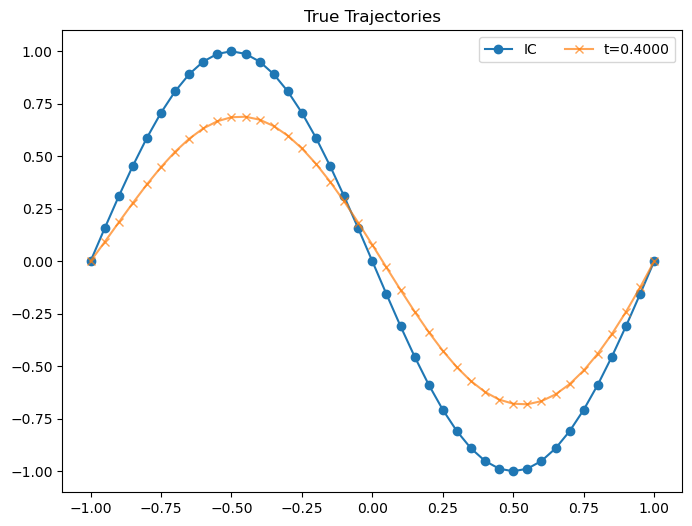

In [9]:
plt.figure(figsize=(8,6))
domain = np.linspace(-1, 1, 41)
plt.plot(domain, true_IC, marker='o', label="IC")

for t, traj in enumerate(true_traj):
    plt.plot(domain, traj, marker='x', label=f"t={chkpts[t]:.4f}", alpha=0.7)
    
plt.legend(ncol=2)
plt.title("True Trajectories")

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "trajectories.png"))
    plt.savefig(os.path.join(fig_dir, "trajectories.pdf"))

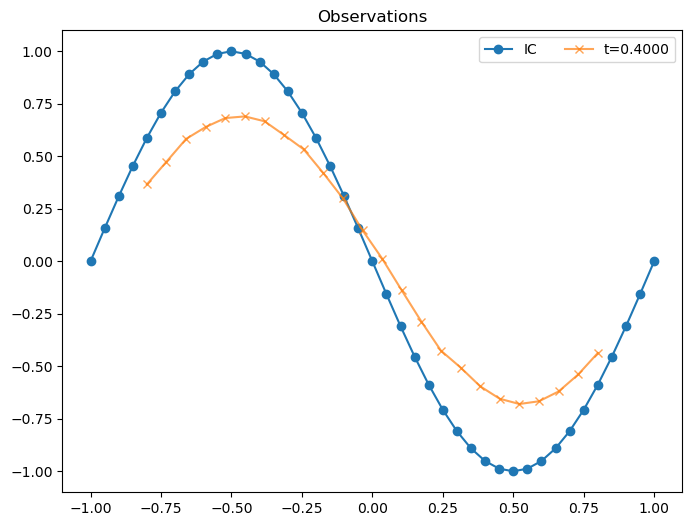

In [10]:
plt.figure(figsize=(8,6))
plt.plot(domain, true_IC, marker='o', label="IC")

for t, ob in enumerate(obs):
    plt.plot(s_pts, ob, marker='x', label=f"t={chkpts[t]:.4f}", alpha=0.7)
    
plt.legend(ncol=3)
plt.title("Observations")

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "observations.png"))
    plt.savefig(os.path.join(fig_dir, "observations.pdf"))

## Select the prior
Use a exponential kernel for the 1D case.  

In [11]:
kern_nugget = 1e-6 # Small value to add along the diagonal to make SPD

# Generate a kernel using GPy
kern = GPy.kern.Exponential(input_dim=1, variance=1, lengthscale=1.0)
#kern = GPy.kern.PeriodicExponential(input_dim=1, variance=1, lengthscale=1.0)
X    = model.get_model_grid()[:, np.newaxis] # make it a column vector
K    = kern.K(X)
K   += kern_nugget*np.eye(K.shape[0])

mu   = np.zeros_like(true_IC) # Can also make a nonzero mean if needed

Look at the prior covariance matrix.

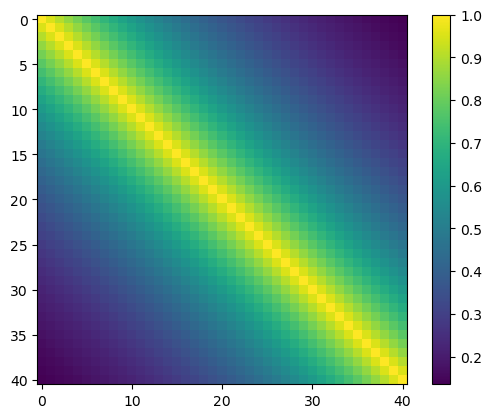

In [12]:
plt.imshow(K)
plt.colorbar()

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "prior_cov.png"))
    plt.savefig(os.path.join(fig_dir, "prior_cov.pdf"))

Check the condition of the prior.

In [13]:
print(f"Condition of the prior covariance: {np.linalg.cond(K):.4f}")

Condition of the prior covariance: 930.9354


Sample some elements from this prior.

In [14]:
num_samples = 200

# Get the cholesky facotr
R = np.linalg.cholesky(K)

# Sample
rand_draws  = np.random.randn(X.shape[0], num_samples) # Columns are samples
prior_draws = R @ rand_draws

# Shift every column by the mean
prior_draws += mu[:, np.newaxis]

Plot them to verify the prior

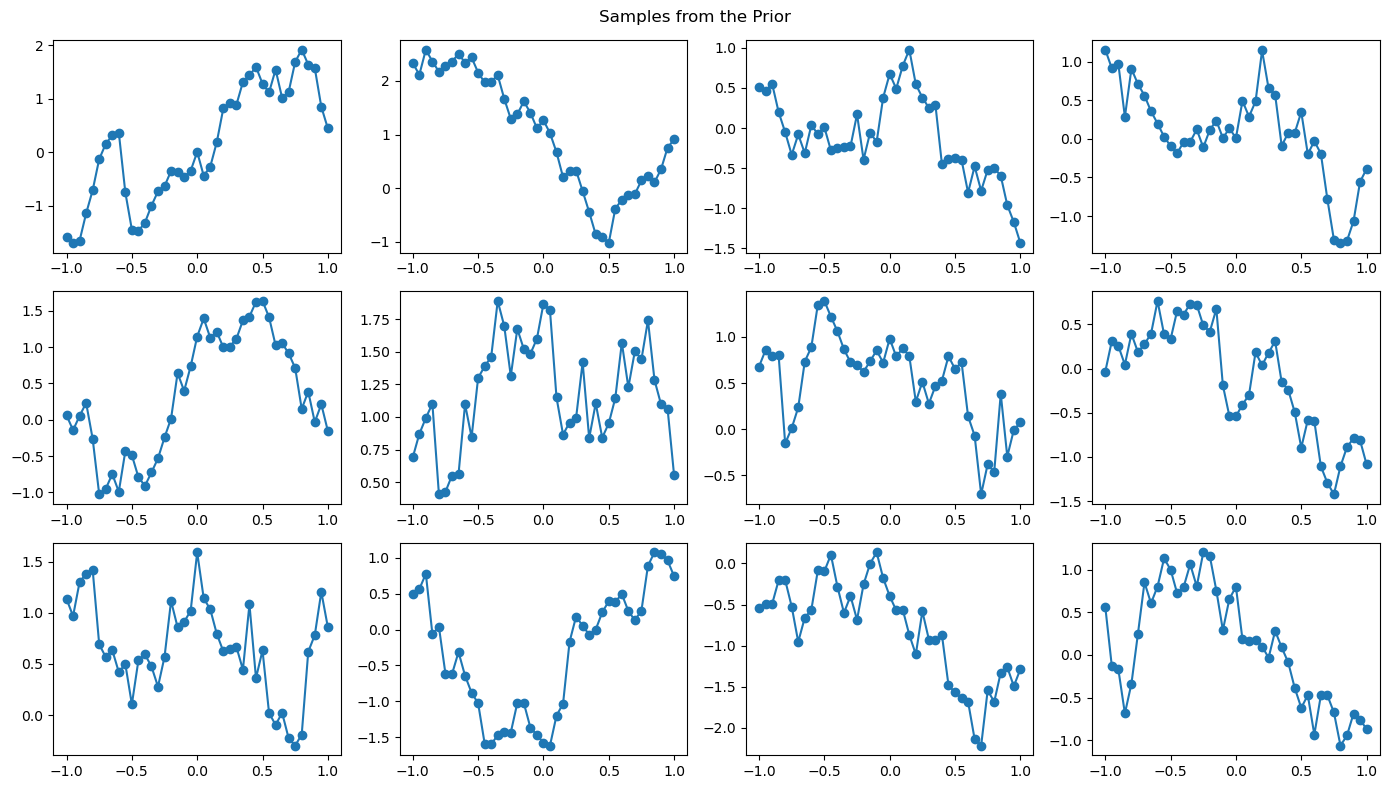

In [15]:
fig = plt.figure(figsize = (14, 8))

nr, nc = 3, 4
for i in range(nr):
    for j in range(nc):
        ax = fig.add_subplot(nr, nc, i*nc + j + 1)
        sample = prior_draws[:, np.random.choice(prior_draws.shape[1])]
        plt.plot(X, sample, marker='o')
        
fig.suptitle("Samples from the Prior");
fig.tight_layout()

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "prior_samples.png"))
    plt.savefig(os.path.join(fig_dir, "prior_samples.pdf"))

In [16]:
if (save_file):
    print(f"Saving the problem parameters.")

    with shelve.open(db_name) as db:
        db["K"]           = K
        db["mu"]          = mu 
        db["kern_nugget"] = kern_nugget

## Solve the full problem
Construct the forward operator, prior, and noise covariance matrices.

In [17]:
# Create the prior and prior operator
prior = GaussianErrorModel(configs={'size': model.state_size, 'mean': mu, 'variance': K})

# Create the prior scipy operator
Gamma_pr_inv = LinearOperator((model.state_size, model.state_size), matvec=prior.covariance_inv_matvec)

# Create the noise scipy operator
Gamma_ns     = LinearOperator((obsop.shape[0], obsop.shape[0]), matvec=obsns.covariance_matvec)
Gamma_ns_inv = LinearOperator((obsop.shape[0], obsop.shape[0]), matvec=obsns.covariance_inv_matvec)

# Create the pyoed forward operator
F_pyoed = create_pyoed_oper(model, obsop, prior, obsns, tspan, chkpts)

# Create the scipy forward operator
F = LinearOperator((obsop.shape[0], model.state_size),
            matvec=A_forward_op(F_pyoed), rmatvec=A_adjoint_op(F_pyoed))

Solve the inverse problem with the full operator.

In [18]:
# Create the CG matrix
alpha     = 1.0
A_full = (F.T @ Gamma_ns_inv @ F) + (alpha * Gamma_pr_inv)
b_full = (F.T @ Gamma_ns_inv @ obs[0]) + (alpha * Gamma_pr_inv @ mu)

Solve using either CG or Gaussian Elimination.

In [19]:
# Toggle CG flag for converting all matrices to dense and use a direct solver
solve_cg = True
alpha    = 1.0
maxiters = 300

x_full, r_full, o_full, _, _ = solve_invprob_cached(F, Gamma_ns_inv, Gamma_pr_inv, obs[0], mu, alpha,
                                    solve_cg=solve_cg, maxiters=maxiters)
    
print(f"Full residual  : {r_full:.4f}")
print(f"Full objective : {o_full:.4f}")
print(f"Full error     : {np.linalg.norm(x_full - true_IC):.4f}")

Full residual  : 0.4084
Full objective : 15.8770
Full error     : 0.5994


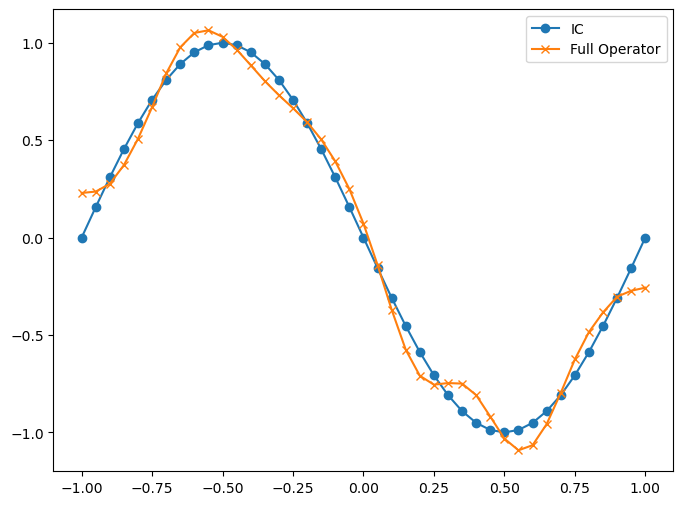

In [20]:
plt.figure(figsize=(8,6))
domain = np.linspace(-1, 1, 41)
plt.plot(domain, true_IC, marker='o', label="IC")
plt.plot(domain, x_full, marker='x', label='Full Operator')
    
plt.legend()

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "full_sol.png"))
    plt.savefig(os.path.join(fig_dir, "full_sol.pdf"))

In [21]:
if (save_file):
    print(f"Saving the problem parameters.")

    with shelve.open(db_name) as db:
        db["solve_cg"]  = solve_cg
        db["maxiters"]  = maxiters
        db["x_full"]    = x_full
        db["r_full"]    = r_full
        db["o_full"]    = o_full

## Run the deterministic CSSP experiment
Set the different parameters and tune hyperparamters.

In [22]:
print(f"Selecting {k} sensors.")

Selecting 8 sensors.


Form the prior preconditioned operator and approximate the CSSP solution.

In [23]:
Fpr = LinearOperator((obsop.shape[0], model.state_size),
            matvec=A_forward_op(F_pyoed, F_pyoed.prior, F_pyoed.observation_error_model), 
            rmatvec=A_adjoint_op(F_pyoed, F_pyoed.prior, F_pyoed.observation_error_model))

Apr = Fpr.T

In [24]:
full_dopt, _ = compute_dopt(Apr)
print(f"Full D-opt: {full_dopt:.4f}")

Full D-opt: 55.9389


In [25]:
detqr_kidx, detqr_dopt, S_detqr, _ = detcssp(Apr, k, typ='dense')
print(f"Selected indices:\n{detqr_kidx}")
print(f"DetCSSP D-opt: {detqr_dopt:.4f}")

Selected indices:
[23  0 20  3 10 13 17  7]
DetCSSP D-opt: 47.4787


In [26]:
detrr_kidx, detrr_dopt, S_detrr, _ = detcssp(Apr, k, typ='dense', qrtyp='srrqr')
print(f"Selected indices:\n{detrr_kidx}")
print(f"DetCSSP D-opt: {detrr_dopt:.4f}")

Number of swaps performed: 0
Selected indices:
[23  0 20  3 10 13 17  7]
DetCSSP D-opt: 47.4787


Plot the selected sensors.

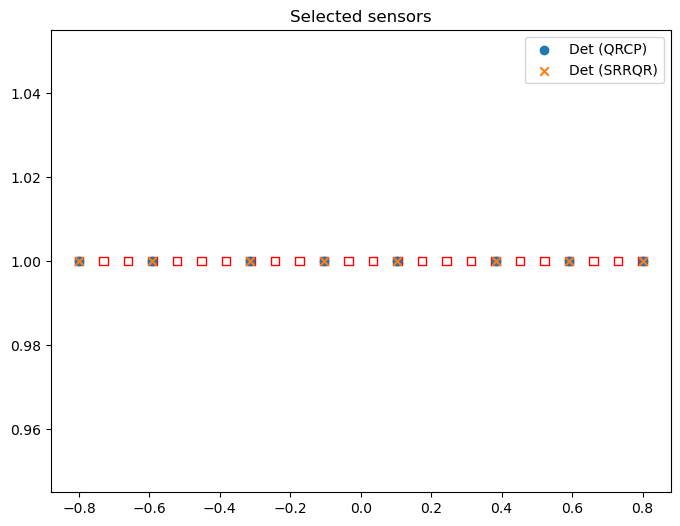

In [27]:
plt.figure(figsize=(8,6))

obsgrid = obsop.get_observation_grid()
plt.scatter(obsgrid, np.ones_like(obsgrid), marker='s', facecolors='none', edgecolors='r')
plt.scatter(obsgrid[detqr_kidx], np.ones_like(detqr_kidx), marker='o', label="Det (QRCP)")
plt.scatter(obsgrid[detrr_kidx], np.ones_like(detrr_kidx), marker='x', label="Det (SRRQR)")

plt.title("Selected sensors")
plt.legend()

In [28]:
if (save_file):
    print(f"Saving the problem parameters.")

    with shelve.open(db_name) as db:
        db["alpha"]       = alpha
        
        db["detqr_kidx"]  = detqr_kidx
        db["detqr_dopt"]  = detqr_dopt
        db["S_detqr"]     = S_detqr
        
        db["detrr_kidx"]  = detrr_kidx
        db["detrr_dopt"]  = detrr_dopt
        db["S_detrr"]     = S_detrr

Tune the `alpha` parameter.

In [29]:
alphas    = np.logspace(-5.0, 2.0, 16)
alpha_res = np.zeros_like(alphas)
alpha_obj = np.zeros_like(alphas)

# Terms in the objective
alpha_data_misfit  = np.zeros_like(alphas)
alpha_prior_misfit = np.zeros_like(alphas)

# Store the solutions
x_alphas  = []

# True residuals (can't be used for alpha selections)
alpha_ic_err = np.zeros_like(alphas)

for idx, alp in enumerate(alphas):
    # Solve with current alpha
    x_alp, r_alp, o_alp, o_dm, o_pm = solve_invprob(F, Gamma_ns, Gamma_pr_inv, 
                                        obs[0], mu, alp, S_detqr.T,
                                        solve_cg=solve_cg, maxiters=maxiters)
    
    # Store stuff
    x_alphas.append(x_alp)
    
    alpha_res[idx] = r_alp
    alpha_obj[idx] = o_alp
    
    alpha_data_misfit[idx]  = o_dm
    alpha_prior_misfit[idx] = o_pm
    
    # Compute true errors
    alpha_ic_err[idx] = np.linalg.norm(x_alp - true_IC)
    
print(f"Best residual (alpha)  : {np.min(alpha_res) :.4f} ({alphas[np.argmin(alpha_res)]:.1e})")
print(f"Best objective (alpha) : {np.min(alpha_obj) :.4f} ({alphas[np.argmin(alpha_obj)]:.1e})")
print(f"Best error (alpha)     : {np.min(alpha_ic_err) :.4f} ({alphas[np.argmin(alpha_ic_err)]:.1e})")

Best residual (alpha)  : 0.0038 (1.0e-05)
Best objective (alpha) : 0.0000 (1.0e-05)
Best error (alpha)     : 0.5682 (5.4e-02)


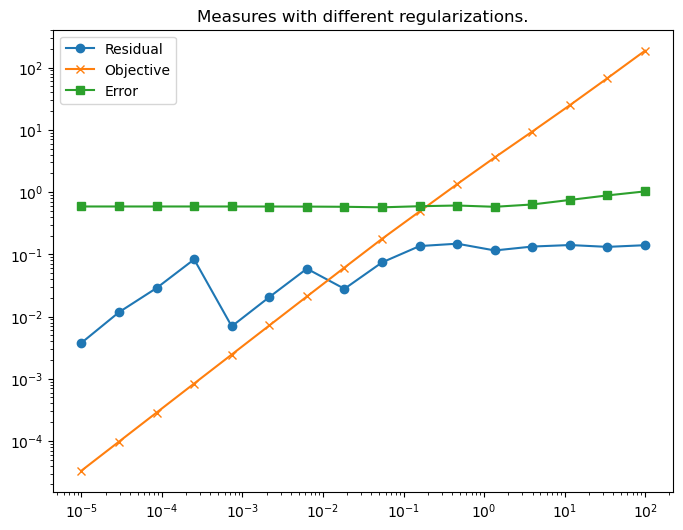

In [30]:
plt.figure(figsize=(8,6))
plt.loglog(alphas, alpha_res, marker='o', label='Residual')
plt.loglog(alphas, alpha_obj, marker='x', label='Objective')
plt.loglog(alphas, alpha_ic_err, marker='s', label='Error')

plt.title("Measures with different regularizations.")
plt.legend()

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "alpha_metrics.png"))
    plt.savefig(os.path.join(fig_dir, "alpha_metrics.pdf"))

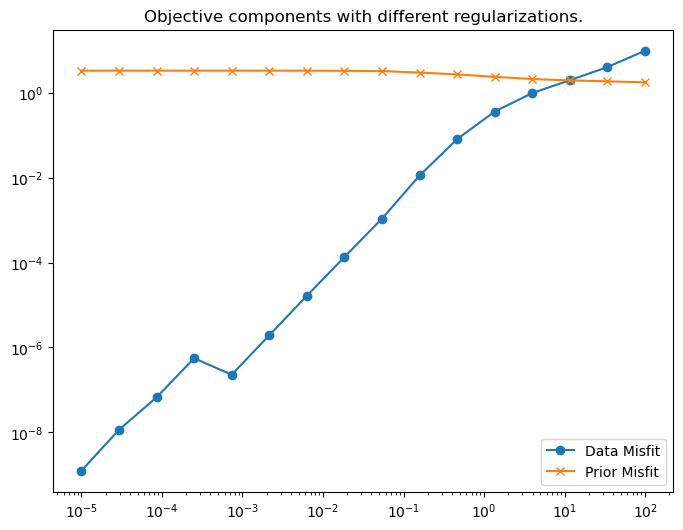

In [31]:
plt.figure(figsize=(8,6))
plt.loglog(alphas, alpha_data_misfit, marker='o', label='Data Misfit')
plt.loglog(alphas, alpha_prior_misfit, marker='x', label='Prior Misfit')

plt.title("Objective components with different regularizations.")
plt.legend()

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "alpha_metrics2.png"))
    plt.savefig(os.path.join(fig_dir, "alpha_metrics2.pdf"))

Compute the noise levels.

In [32]:
# Compute the true IC data misfit
_, IC_dm, _ = compute_obj(F, Gamma_ns, Gamma_pr_inv, 
                            obs[0], mu, alpha, true_IC, S_detqr.T)

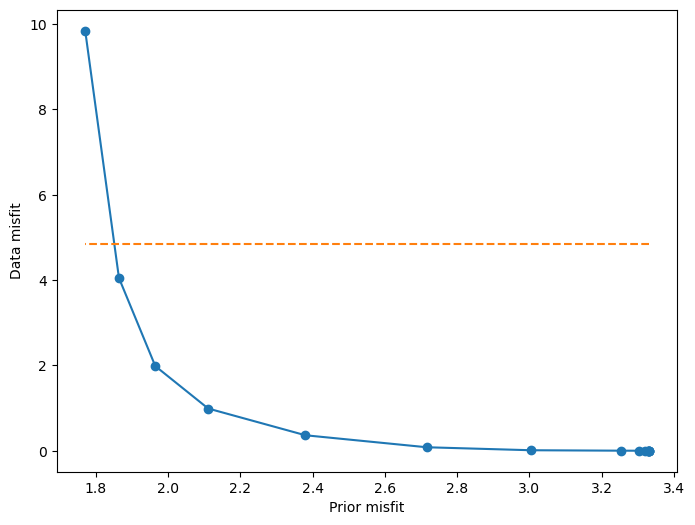

In [33]:
plt.figure(figsize=(8,6))
plt.plot(alpha_prior_misfit, alpha_data_misfit, marker='o')
plt.plot(alpha_prior_misfit, IC_dm*np.ones_like(alphas), ls='--')

plt.xlabel("Prior misfit")
plt.ylabel("Data misfit")

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "alpha_elbow.png"))
    plt.savefig(os.path.join(fig_dir, "alpha_elbow.pdf"))

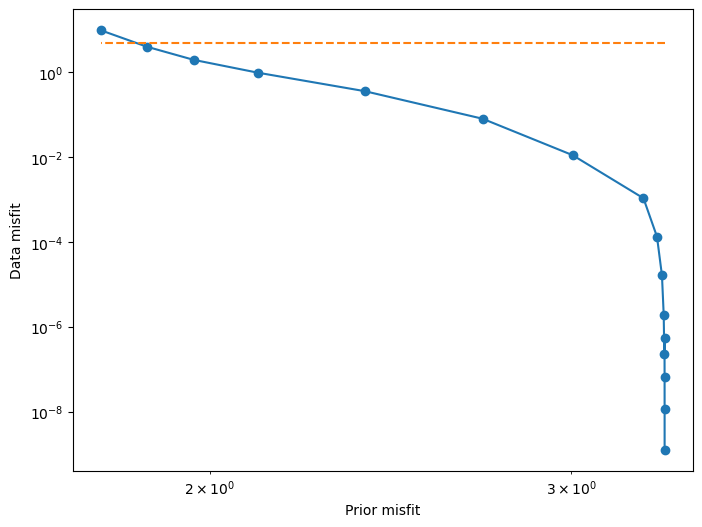

In [34]:
plt.figure(figsize=(8,6))
plt.loglog(alpha_prior_misfit, alpha_data_misfit, marker='o')
plt.plot(alpha_prior_misfit, IC_dm*np.ones_like(alphas), ls='--')

plt.xlabel("Prior misfit")
plt.ylabel("Data misfit")

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "alpha_elbow2.png"))
    plt.savefig(os.path.join(fig_dir, "alpha_elbow2.pdf"))

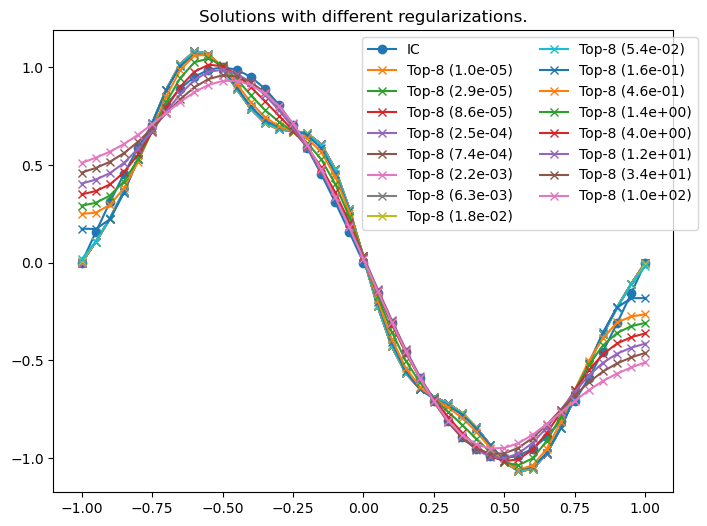

In [35]:
plt.figure(figsize=(8,6))
domain = np.linspace(-1, 1, 41)
plt.plot(domain, true_IC, marker='o', label="IC")

for idx, x_alp in enumerate(x_alphas):
    alp = alphas[idx]
    plt.plot(domain, x_alp, marker='x', label=f'Top-{k} ({alp:.1e})')

plt.title("Solutions with different regularizations.")
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2, loc="best")

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "alpha_sols.png"))
    plt.savefig(os.path.join(fig_dir, "alpha_sols.pdf"))

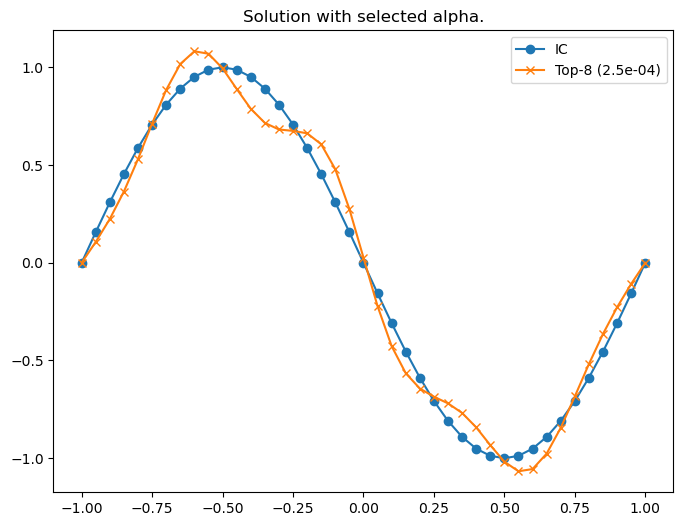

In [36]:
sel_alpha_idx = 3
sel_alpha     = alphas[sel_alpha_idx]
sel_x_alpha   = x_alphas[sel_alpha_idx]

sel_obj       = alpha_obj[sel_alpha_idx]
sel_res       = alpha_res[sel_alpha_idx]
sel_err       = alpha_ic_err[sel_alpha_idx]

plt.figure(figsize=(8,6))
domain = np.linspace(-1, 1, 41)
plt.plot(domain, true_IC, marker='o', label="IC")
plt.plot(domain, sel_x_alpha, marker='x', label=f'Top-{k} ({sel_alpha:.1e})')

plt.title("Solution with selected alpha.")
plt.legend()

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "selalpha_sol.png"))
    plt.savefig(os.path.join(fig_dir, "selalpha_sol.pdf"))

Use selected `alpha` for computing D-optimality and reconstructions. 

In [37]:
full_dopt, _  = compute_dopt(Apr / sel_alpha)
detqr_dopt, _ = compute_dopt((Apr / sel_alpha) @ aslinearoperator(S_detqr))
detrr_dopt, _ = compute_dopt((Apr / sel_alpha) @ aslinearoperator(S_detrr))

print(f"D-optimality with alpha = {sel_alpha:.4f}")
print(f"Full operator = {full_dopt:.4f}")
print(f"Det (QR)      = {detqr_dopt:.4f}")
print(f"Det (sRRQR)   = {detrr_dopt:.4f}")

D-optimality with alpha = 0.0003
Full operator = 316.7071
Det (QR)      = 179.4478
Det (sRRQR)   = 179.4478


In [38]:
# Solve the inverse problem (det)
x_detqr, r_detqr, o_detqr, _, _ = solve_invprob(F, Gamma_ns, Gamma_pr_inv, obs[0], mu, sel_alpha, S_detqr.T,
                                solve_cg=solve_cg, maxiters=maxiters)

x_detrr, r_detrr, o_detrr, _, _ = solve_invprob(F, Gamma_ns, Gamma_pr_inv, obs[0], mu, sel_alpha, S_detrr.T,
                                solve_cg=solve_cg, maxiters=maxiters)

In [39]:
if (save_file):
    print(f"Saving the problem parameters.")

    with shelve.open(db_name) as db:
        db["alphas"]             = alphas
        db["alpha_res"]          = alpha_res
        db["alpha_obj"]          = alpha_obj
        db["alpha_data_misfit"]  = alpha_data_misfit
        db["alpha_prior_misfit"] = alpha_prior_misfit
        db["x_alphas"]           = x_alphas 
        db["alpha_ic_err"]       = alpha_ic_err
        db["IC_dm"]              = IC_dm
        db["sel_alpha_idx"]      = sel_alpha_idx
        db["sel_alpha"]          = sel_alpha
        db["sel_x_alpha"]        = sel_x_alpha
        db["sel_obj"]            = sel_obj
        db["sel_res"]            = sel_res
        db["sel_err"]            = sel_err

        # Store det results
        db["x_detqr"] = x_detqr
        db["r_detqr"] = r_detqr
        db["o_detqr"] = o_detqr

        db["x_detrr"] = x_detrr
        db["r_detrr"] = r_detrr
        db["o_detrr"] = o_detrr

        # Store recomputed D-opts
        db["full_dopt"]  = full_dopt
        db["detqr_dopt"] = detqr_dopt
        db["detrr_dopt"] = detrr_dopt

## Run the random CSSP experiments.

Call the different algorithms and solve the inverse problems.

In [40]:
rr_idx, _, S_rr, _ = randcssp(Apr, k, typ='srrqr', rseed=seed)

# Compute D-optimality
rr_dopt, _ = compute_dopt((Apr / sel_alpha) @ aslinearoperator(S_rr))       

# Solve the inverse problem
x_rr, r_rr, o_rr, _, _ = solve_invprob(F, Gamma_ns, Gamma_pr_inv, obs[0], mu, sel_alpha, S_rr.T,
                                solve_cg=solve_cg, maxiters=maxiters)

Number of swaps performed: 0


In [41]:
qr_idx, _, S_qr, _ = randcssp(Apr, k, typ='qr', rseed=seed)

# Compute D-optimality
qr_dopt, _ = compute_dopt((Apr / sel_alpha) @ aslinearoperator(S_qr))

# Solve the inverse problem
x_qr, r_qr, o_qr, _, _ = solve_invprob(F, Gamma_ns, Gamma_pr_inv, obs[0], mu, sel_alpha, S_qr.T,
                                solve_cg=solve_cg, maxiters=maxiters)

In [42]:
cx_idx, _, S_cx, _ = randcssp(Apr, k, typ='colsample', rseed=seed)

# Compute D-optimality
cx_dopt, _ = compute_dopt((Apr / sel_alpha) @ aslinearoperator(S_cx))

# Solve the inverse problem
x_cx, r_cx, o_cx, _, _ = solve_invprob(F, Gamma_ns, Gamma_pr_inv, obs[0], mu, sel_alpha, S_cx.T,
                                solve_cg=solve_cg, maxiters=maxiters)

In [43]:
hy_idx, _, S_hy, _ = randcssp(Apr, k, typ='hybrid', rseed=seed)

# Compute D-optimality
hy_dopt, _ = compute_dopt((Apr / sel_alpha) @ aslinearoperator(S_hy))

# Solve the inverse problem
x_hy, r_hy, o_hy, _, _ = solve_invprob(F, Gamma_ns, Gamma_pr_inv, obs[0], mu, sel_alpha, S_hy.T,
                                solve_cg=solve_cg, maxiters=maxiters)

Save stuff.

In [44]:
if (save_file):
    print(f"Saving the problem parameters.")

    with shelve.open(db_name) as db:
        # sRRQR
        db["rr_idx"]  = rr_idx
        db["rr_dopt"] = rr_dopt
        db["S_rr"]    = S_rr
        db["x_rr"]    = x_rr
        db["r_rr"]    = r_rr
        db["o_rr"]    = o_rr
        
        # QR
        db["qr_idx"]  = qr_idx
        db["qr_dopt"] = qr_dopt
        db["S_qr"]    = S_qr
        db["x_qr"]    = x_qr
        db["r_qr"]    = r_qr
        db["o_qr"]    = o_qr
        
        # Colsample
        db["cx_dx"]   = cx_idx
        db["cx_dopt"] = cx_dopt
        db["S_cx"]    = S_cx
        db["x_cx"]    = x_cx
        db["r_cx"]    = r_cx
        db["o_cx"]    = o_cx
        
        # Hybrid
        db["hy_idx"]  = hy_idx
        db["hy_dopt"] = hy_dopt
        db["S_hy"]    = S_hy
        db["x_hy"]    = x_hy
        db["r_hy"]    = r_hy
        db["o_hy"]    = o_hy

## Run the greedy method.

In [45]:
gd_idx, _, S_gd, _ = greedydopt(Apr, k)

# Compute D-optimality
gd_dopt, _ = compute_dopt((Apr / sel_alpha) @ aslinearoperator(S_gd))

# Solve the inverse problem
x_gd, r_gd, o_gd, _, _ = solve_invprob(F, Gamma_ns, Gamma_pr_inv, obs[0], mu, sel_alpha, S_gd.T,
                                solve_cg=solve_cg, maxiters=maxiters)

Save stuff.

In [46]:
if (save_file):
    print(f"Saving the problem parameters.")

    with shelve.open(db_name) as db:
        # Greedy
        db["gd_idx"]  = gd_idx
        db["gd_dopt"] = gd_dopt
        db["S_gd"]    = S_gd
        db["x_gd"]    = x_gd
        db["r_gd"]    = r_gd
        db["o_gd"]    = o_gd


## Results

In [47]:
print(f"sRRQR indices  : {rr_idx}")
print(f"QR indices     : {qr_idx}")
print(f"CX indices     : {cx_idx}")
print(f"Hy indices     : {hy_idx}")
print(f"Greedy indices : {gd_idx}")

sRRQR indices  : [23  0 20  3 10 17 13  7]
QR indices     : [23  0 20  3 10 17 13  7]
CX indices     : [22 16 14  0 23 19 10  6  0 10  6  7 11  8 12 18  2]
Hy indices     : [23  0 10  7 16 19 14  2]
Greedy indices : [8, 18, 2, 13, 23, 5, 15, 0]


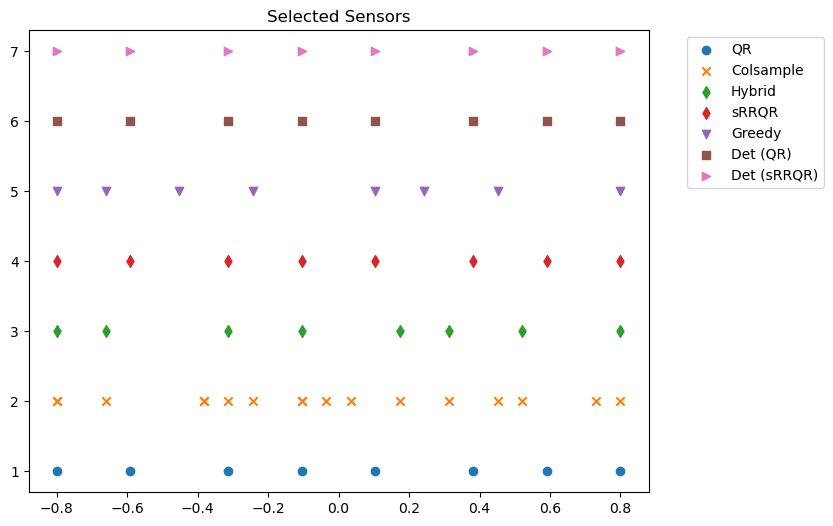

In [48]:
plt.figure(figsize=(8,6))

obsgrid = obsop.get_observation_grid()
plt.scatter(obsgrid[qr_idx], np.ones_like(qr_idx), marker='o', label='QR')
plt.scatter(obsgrid[cx_idx], 2*np.ones_like(cx_idx), marker='x', label='Colsample')
plt.scatter(obsgrid[hy_idx], 3*np.ones_like(hy_idx), marker='d', label='Hybrid')
plt.scatter(obsgrid[rr_idx], 4*np.ones_like(hy_idx), marker='d', label='sRRQR')
plt.scatter(obsgrid[gd_idx], 5*np.ones_like(gd_idx), marker='v', label='Greedy')
plt.scatter(obsgrid[detqr_kidx], 6*np.ones_like(detqr_kidx), marker='s', label='Det (QR)')
plt.scatter(obsgrid[detrr_kidx], 7*np.ones_like(detrr_kidx), marker='>', label='Det (sRRQR)')


plt.title("Selected Sensors")
plt.legend(bbox_to_anchor=(1.05, 1), loc="best")
fig.tight_layout()

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "sel_sensors.png"))
    plt.savefig(os.path.join(fig_dir, "sel_sensors.pdf"))

D-optimality results.

In [49]:
print("D-Optimality.")
print(f"Full operator : {full_dopt :.4f}\n")

print("CSSP operators.")
print(f"Det (QR)      : {detqr_dopt :.4f}")
print(f"Det (sRRQR)   : {detrr_dopt :.4f}")
print(f"Greedy        : {gd_dopt :.4f}")
print(f"sRRQR         : {rr_dopt :.4f}")
print(f"QR            : {qr_dopt :.4f}")
print(f"Colsample     : {cx_dopt :.4f}")
print(f"Hybrid        : {hy_dopt :.4f}\n")

D-Optimality.
Full operator : 316.7071

CSSP operators.
Det (QR)      : 179.4478
Det (sRRQR)   : 179.4478
Greedy        : 177.9539
sRRQR         : 179.4479
QR            : 179.4479
Colsample     : 253.5310
Hybrid        : 178.4348



Reconstruction errors.

In [50]:
print("Reconstruction error.")
tICnorm = np.linalg.norm(true_IC)
rerr_fn = lambda x: np.linalg.norm(x - true_IC) / tICnorm
print(f"Full operator : {rerr_fn(x_full) :.4f}\n")

print("CSSP operators.")
print(f"Det (QR)      : {rerr_fn(x_detqr) :.4f}")
print(f"Det (sRRQR)   : {rerr_fn(x_detrr) :.4f}")
print(f"Greedy        : {rerr_fn(x_gd) :.4f}")
print(f"sRRQR         : {rerr_fn(x_rr) :.4f}")
print(f"QR            : {rerr_fn(x_qr) :.4f}")
print(f"Colsample     : {rerr_fn(x_cx) :.4f}")
print(f"Hybrid        : {rerr_fn(x_hy) :.4f}\n")

Reconstruction error.
Full operator : 0.1340

CSSP operators.
Det (QR)      : 0.1310
Det (sRRQR)   : 0.1310
Greedy        : 0.2407
sRRQR         : 0.1310
QR            : 0.1310
Colsample     : 4.8038
Hybrid        : 0.3919



Objectives.

In [51]:
print("Objectives.")
print("CSSP operators.")
print(f"Det (QR)      : {o_detqr :.4f}")
print(f"Det (sRRQR)   : {o_detrr :.4f}")
print(f"Greedy        : {o_gd :.4f}")
print(f"sRRQR         : {o_rr :.4f}")
print(f"QR            : {o_qr :.4f}")
print(f"Colsample     : {o_cx :.4f}")
print(f"Hybrid        : {o_hy :.4f}\n")

Objectives.
CSSP operators.
Det (QR)      : 0.0008
Det (sRRQR)   : 0.0008
Greedy        : 0.0012
sRRQR         : 0.0008
QR            : 0.0008
Colsample     : 1.7490
Hybrid        : 0.0022



Residuals.

In [52]:
print("Residuals.")
print("CSSP operators.")
print(f"Det (QR)      : {r_detqr :.4f}")
print(f"Det (sRRQR)   : {r_detrr :.4f}")
print(f"Greedy        : {r_gd :.4f}")
print(f"sRRQR         : {r_rr :.4f}")
print(f"QR            : {r_qr :.4f}")
print(f"Colsample     : {r_cx :.4f}")
print(f"Hybrid        : {r_hy :.4f}\n")

Residuals.
CSSP operators.
Det (QR)      : 0.0828
Det (sRRQR)   : 0.0828
Greedy        : 0.0456
sRRQR         : 0.0828
QR            : 0.0828
Colsample     : 0.1929
Hybrid        : 0.0801



Plot stuff.

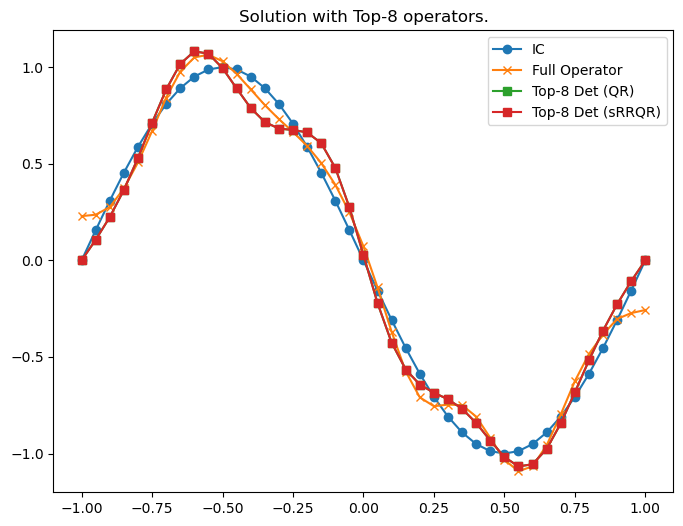

In [53]:
plt.figure(figsize=(8,6))
domain = np.linspace(-1, 1, 41)
plt.plot(domain, true_IC, marker='o', label="IC")
plt.plot(domain, x_full, marker='x', label=f'Full Operator')
plt.plot(domain, x_detqr, marker='s', label=f'Top-{k} Det (QR)')
plt.plot(domain, x_detrr, marker='s', label=f'Top-{k} Det (sRRQR)')

plt.title(f"Solution with Top-{k} operators.")
plt.legend()

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "subset_sols_det.png"))
    plt.savefig(os.path.join(fig_dir, "subset_sols_det.pdf"))

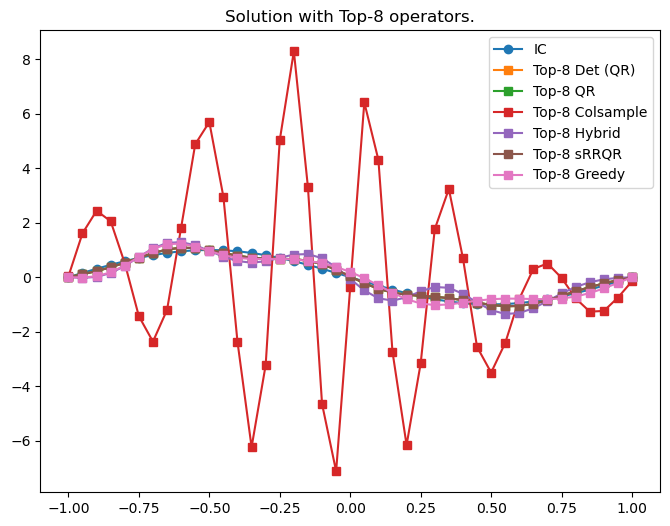

In [54]:
plt.figure(figsize=(8,6))
domain = np.linspace(-1, 1, 41)
plt.plot(domain, true_IC, marker='o', label="IC")
plt.plot(domain, x_detqr, marker='s', label=f'Top-{k} Det (QR)')
plt.plot(domain, x_qr, marker='s', label=f'Top-{k} QR')
plt.plot(domain, x_cx, marker='s', label=f'Top-{k} Colsample')
plt.plot(domain, x_hy, marker='s', label=f'Top-{k} Hybrid')
plt.plot(domain, x_rr, marker='s', label=f'Top-{k} sRRQR')
plt.plot(domain, x_gd, marker='s', label=f'Top-{k} Greedy')

plt.title(f"Solution with Top-{k} operators.")
plt.legend()

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "subset_sols_rand.png"))
    plt.savefig(os.path.join(fig_dir, "subset_sols_rand.pdf"))

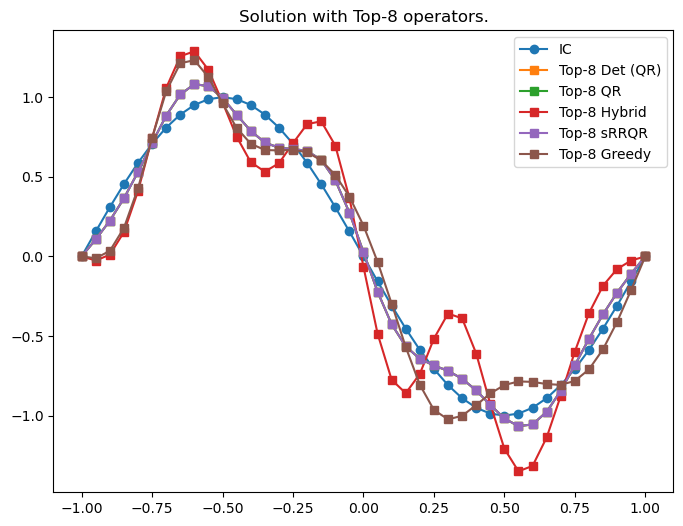

In [55]:
plt.figure(figsize=(8,6))
domain = np.linspace(-1, 1, 41)
plt.plot(domain, true_IC, marker='o', label="IC")
plt.plot(domain, x_detqr, marker='s', label=f'Top-{k} Det (QR)')
plt.plot(domain, x_qr, marker='s', label=f'Top-{k} QR')
#plt.plot(domain, x_cx, marker='s', label=f'Top-{k} Colsample')
plt.plot(domain, x_hy, marker='s', label=f'Top-{k} Hybrid')
plt.plot(domain, x_rr, marker='s', label=f'Top-{k} sRRQR')
plt.plot(domain, x_gd, marker='s', label=f'Top-{k} Greedy')

plt.title(f"Solution with Top-{k} operators.")
plt.legend()

if (save_figs):
    plt.savefig(os.path.join(fig_dir, "subset_sols_rand2.png"))
    plt.savefig(os.path.join(fig_dir, "subset_sols_rand2.pdf"))